C:\Users\pjw10\OneDrive\ipykernel_3356\2415259808.py:147: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  f0 /= np.trapz(f0, x)
C:\Users\pjw10\OneDrive\ipykernel_3356\2415259808.py:40: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  D = np.trapz(np.exp(wG * G) * f, x)
C:\Users\pjw10\OneDrive\ipykernel_3356\2415259808.py:48: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  total = np.trapz(f, x)


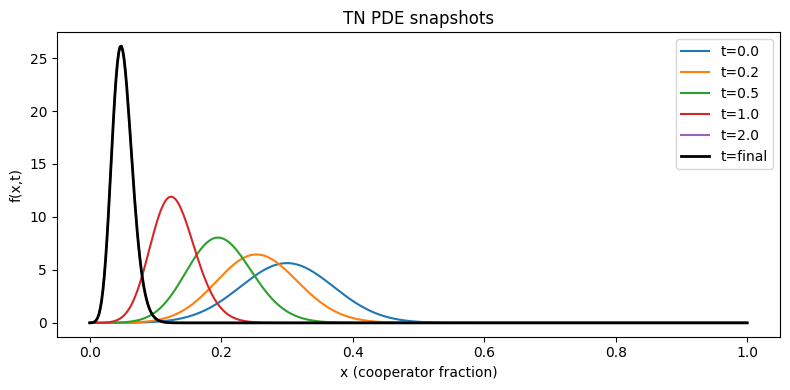

C:\Users\pjw10\OneDrive\ipykernel_3356\2415259808.py:67: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  mean_x = np.trapz(x * f, x)
C:\Users\pjw10\OneDrive\ipykernel_3356\2415259808.py:68: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  var_x = np.trapz((x - mean_x)**2 * f, x)
C:\Users\pjw10\OneDrive\ipykernel_3356\2415259808.py:69: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  meanG = np.trapz(G * f, x)
C:\Users\pjw10\OneDrive\ipykernel_3356\2415259808.py:72: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  entropy = -np.trapz(f * np.log(f + eps), x)


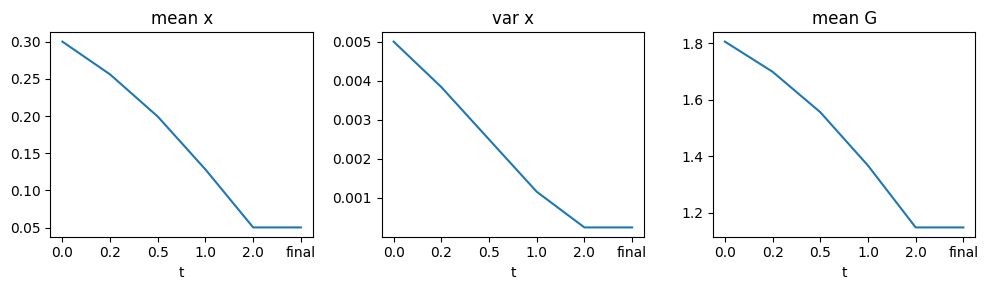

C:\Users\pjw10\OneDrive\ipykernel_3356\2415259808.py:83: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  mean_x = np.trapz(x * f_final, x)


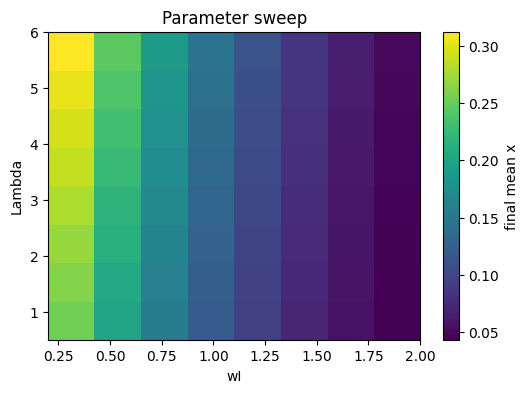

C:\Users\pjw10\OneDrive\ipykernel_3356\2415259808.py:92: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  f /= np.trapz(f, x)
C:\Users\pjw10\OneDrive\ipykernel_3356\2415259808.py:100: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  D = np.trapz(np.exp(wG * G) * f, x)
C:\Users\pjw10\OneDrive\ipykernel_3356\2415259808.py:105: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  f /= np.trapz(f, x)
C:\Users\pjw10\OneDrive\ipykernel_3356\2415259808.py:109: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  meanxs.append(np.trapz(x*f,x))


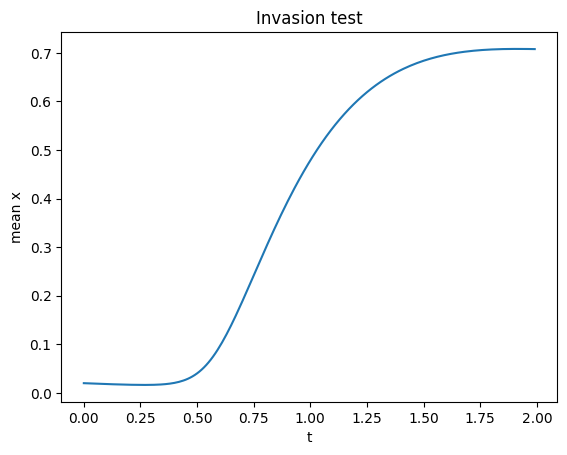

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def fitnesses(x, R, S, T, P):
    piC = R * x + S * (1 - x)
    piD = T * x + P * (1 - x)
    G = piC * x + piD * (1 - x)
    return piC, piD, G

def upwind_step(f, x, dx, dt, v, growth):
    """One conservative upwind step for -∂x(v f) + growth*f.
       v: velocity array on grid points, growth: growth rate array on grid points.
    """
    v_plus = np.maximum(v, 0.0)
    v_minus = np.minimum(v, 0.0)

    flux = v_plus * f + np.roll(v_minus * f, -1)
    flux[-1] = 0.0
    div = (flux - np.roll(flux, 1)) / dx
    dfdt = -div + growth * f
    return dfdt

def run_pde(R, S, T, P, Lambda, wI, wG,
            x, dt, tmax, f0,
            save_times):
    dx = x[1] - x[0]
    f = f0.copy()
    t = 0.0
    snapshots = {}
    times_to_save = set(save_times)
    # store initial if requested
    if 0.0 in times_to_save:
        snapshots[0.0] = f.copy()

    nsteps = int(np.ceil(tmax / dt))
    for step in range(nsteps):
        piC, piD, G = fitnesses(x, R, S, T, P)
        v = wI * x * (1 - x) * (piC - piD)          # within-group velocity
        # Traulsen-Nowak exponential group fitness:
        D = np.trapz(np.exp(wG * G) * f, x)
        growth = Lambda * (np.exp(wG * G) / D - 1.0)

        dfdt = upwind_step(f, x, dx, dt, v, growth)
        f = f + dt * dfdt

        # positivity and renormalize
        f = np.maximum(f, 0.0)
        total = np.trapz(f, x)
        if total <= 0:
            # numerical collapse guard
            f = np.ones_like(f) / (x[-1] - x[0])
            total = np.trapz(f, x)
        f /= total

        t += dt
        # save near requested times (use tolerance)
        for st in save_times:
            if abs(t - st) < 0.5*dt:
                snapshots[st] = f.copy()
    # ensure we have last time
    snapshots['final'] = f.copy()
    return snapshots

# Diagnostics: moments, mean G, entropy ???
def diagnostics(x, f, R, S, T, P):
    piC, piD, G = fitnesses(x, R, S, T, P)
    mean_x = np.trapz(x * f, x)
    var_x = np.trapz((x - mean_x)**2 * f, x)
    meanG = np.trapz(G * f, x)
    # Shannon-like entropy
    eps = 1e-12
    entropy = -np.trapz(f * np.log(f + eps), x)
    return {'mean_x': mean_x, 'var_x': var_x, 'meanG': meanG, 'entropy': entropy}

def sweep_Lambda_wI(L_vals, wI_vals, R,S,T,P, wG, x, dt, tmax, f0):
    heat = np.zeros((len(L_vals), len(wI_vals)))
    for i,L in enumerate(L_vals):
        for j,wI in enumerate(wI_vals):
            snaps = run_pde(R,S,T,P, Lambda=L, wI=wI, wG=wG,
                            x=x, dt=dt, tmax=tmax, f0=f0,
                            save_times=[tmax])
            f_final = snaps.get(tmax, snaps['final'])
            mean_x = np.trapz(x * f_final, x)
            heat[i,j] = mean_x
    return heat

# Invasion test: start near x=0 (almost all defectors) with tiny coop mass
def invasion_test(R,S,T,P, Lambda, wI, wG, x, dt, tmax):
    # initial: bulk at x=0 plus tiny gaussian near small x0
    f = np.ones_like(x) * 1e-6
    f += np.exp(-(x - 0.02)**2 / (2*(0.005**2)))  # tiny coop blob around 0.02
    f /= np.trapz(f, x)
    times = []
    meanxs = []
    t=0.0
    nsteps = int(np.ceil(tmax/dt))
    for step in range(nsteps):
        piC, piD, G = fitnesses(x, R, S, T, P)
        v = wI * x * (1-x) * (piC - piD)
        D = np.trapz(np.exp(wG * G) * f, x)
        growth = Lambda * (np.exp(wG * G) / D - 1.0)
        dfdt = upwind_step(f, x, x[1]-x[0], dt, v, growth)
        f = f + dt * dfdt
        f = np.maximum(f, 0.0)
        f /= np.trapz(f, x)
        t += dt
        if step % max(1, nsteps//200) == 0:
            times.append(t)
            meanxs.append(np.trapz(x*f,x))
    return np.array(times), np.array(meanxs), f

# first graph, f vs x in different t(similar with previous)
def plot_snapshots(x, snapshots, title=None):
    plt.figure(figsize=(8,4))
    for k in sorted(snapshots.keys(), key=lambda v: (v!='final', v)):
        if k=='final': continue
        plt.plot(x, snapshots[k], label=f"t={k}")
    plt.plot(x, snapshots['final'], label="t=final", lw=2, color='k')
    plt.xlabel('x (cooperator fraction)')
    plt.ylabel('f(x,t)')
    if title: plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_diagnostics(time_points, diag_list):
    means = [d['mean_x'] for d in diag_list]
    var = [d['var_x'] for d in diag_list]
    meanG = [d['meanG'] for d in diag_list]
    plt.figure(figsize=(10,3))
    plt.subplot(1,3,1); plt.plot(time_points, means); plt.xlabel('t'); plt.title('mean x')
    plt.subplot(1,3,2); plt.plot(time_points, var); plt.xlabel('t'); plt.title('var x')
    plt.subplot(1,3,3); plt.plot(time_points, meanG); plt.xlabel('t'); plt.title('mean G')
    plt.tight_layout()
    plt.show()

if __name__ == '__main__':
    R,S,T,P = 3.0, 0.0, 5.0, 1.0
    Lambda = 3.0
    wI = 1.0
    wG = 1.0
    x = np.linspace(0,1,500)
    dt = 5e-4
    tmax = 2.0

    f0 = np.exp(-((x - 0.3) ** 2) / 0.01)
    f0 /= np.trapz(f0, x)
    save_times = [0.0, 0.2, 0.5, 1.0, tmax]
    snaps = run_pde(R,S,T,P, Lambda, wI, wG, x, dt, tmax, f0, save_times)
    plot_snapshots(x, snaps, title="TN PDE snapshots")

    float_keys = sorted([k for k in snaps.keys() if isinstance(k, float)])
    diag_list = [diagnostics(x, snaps[t], R,S,T,P) for t in float_keys]
    diag_list.append(diagnostics(x, snaps['final'], R,S,T,P))
    times_sorted = float_keys + ['final']
    plot_diagnostics(times_sorted, diag_list)

    L_vals = np.linspace(0.5, 6.0, 8)
    wI_vals = np.linspace(0.2, 2.0, 8)
    heat = sweep_Lambda_wI(L_vals, wI_vals, R,S,T,P, wG, x, dt, 1.0, f0)
    plt.figure(figsize=(6,4)); plt.imshow(heat, origin='lower',
               extent=[wI_vals[0], wI_vals[-1], L_vals[0], L_vals[-1]], aspect='auto')
    plt.colorbar(label='final mean x'); plt.xlabel('wI'); plt.ylabel('Lambda'); plt.title('Parameter sweep'); plt.show()

    # invasion test(begin when x=0, and see the chaning of x)
    times, meanxs, f_end = invasion_test(R,S,T,P, Lambda, wI, wG, x, dt, 2.0)
    plt.plot(times, meanxs); plt.xlabel('t'); plt.ylabel('mean x'); plt.title('Invasion test'); plt.show()


In [13]:
# calculate the Λc, to resist that mutation destroy the coorperation(f0<f2)
import numpy as np
from scipy import linalg
from scipy.optimize import brentq

#M
def build_M(Lambda, mu, params):
    w_I = params.get('w_I', 0.1)
    w_G = params.get('w_G', 0.1)
    T = params.get('T', 5.0)
    S = params.get('S', 0.0)
    P = params.get('P', 1.0)
    R = params.get('R', 3.0)
    
    a00 = -mu * (1 + w_I * P) + Lambda * w_G * P
    a01 = (1 - mu) * (1 + w_I * T)
    a02 = 0.0

    a10 = mu * (1 + w_I * P)
    a11 = - (1 - mu) * (2 + w_I * (T + S)) + Lambda * w_G * ((T + S) / 2.0)
    a12 = mu * (1 + w_I * R)

    a20 = 0.0
    a21 = (1 - mu) * (1 + w_I * S)
    a22 = -mu * (1 + w_I * R) + Lambda * w_G * R

    M = np.array([[a00, a01, a02],
                  [a10, a11, a12],
                  [a20, a21, a22]], dtype=float)
    return M


def principal_eigvec_normalized(M, tol_imag=1e-8):
    vals, vecs = linalg.eig(M)
    idx = np.argmax(vals.real)
    v = vecs[:, idx]
    # if np.max(np.abs(v.imag)) > tol_imag:
    #     print("WARNING: principal eigenvector has non-negligible imaginary part; taking real part.")
    v_real = v.real
    s = np.sum(v_real)
    if np.isclose(s, 0.0):
        s = np.sum(np.abs(v_real))
        if np.isclose(s, 0.0):
            raise ValueError("Principal eigenvector sums to zero; cannot normalize.")
        f = v_real / s
    else:
        f = v_real / s
    return f, vals[idx]

def g_of_Lambda(Lambda, mu, params):
    M = build_M(Lambda, mu, params)
    f, eigval = principal_eigvec_normalized(M)
    g = f[2] - f[0]
    return g

def find_Lambda_c(mu, params,
                  Lambda_min=0.0, Lambda_max=10.0,
                  n_scan=1001, tol=1e-6):
    Lambdas = np.linspace(Lambda_min, Lambda_max, n_scan)
    gvals = np.empty_like(Lambdas)
    for i, L in enumerate(Lambdas):
        try:
            gvals[i] = g_of_Lambda(L, mu, params)
        except Exception as e:
            gvals[i] = np.nan
    idx_valid = np.where(~np.isnan(gvals))[0]
    if idx_valid.size == 0:
        return None
    for k in range(len(Lambdas) - 1):
        a, b = gvals[k], gvals[k+1]
        if np.isnan(a) or np.isnan(b):
            continue
        if a == 0.0:
            return Lambdas[k]
        if a * b < 0:
            L_lo, L_hi = Lambdas[k], Lambdas[k+1]
            try:
                root = brentq(lambda L: g_of_Lambda(L, mu, params), L_lo, L_hi, xtol=tol)
                return root
            except Exception as e:
                return 0.5 * (L_lo + L_hi)
    return None

def compute_Lambda_c_for_mu_list(mu_list, params, Lambda_min=0.0, Lambda_max=10.0):
    results = []
    for mu in mu_list:
        try:
            lc = find_Lambda_c(mu, params, Lambda_min=Lambda_min, Lambda_max=Lambda_max)
            results.append((mu, lc))
            print(f"mu={mu:.5f}  -> Lambda_c = {lc}")
        except Exception as e:
            results.append((mu, None))
            print(f"mu={mu:.5f}  -> failed: {e}")
    return results

if __name__ == "__main__":
    params = {
        'w_I': 0.1,
        'w_G': 0.1,
        'T': 5.0,
        'S': 0.0,
        'P': 1.0,
        'R': 3.0
    }
    mu_vals = np.linspace(0.0, 0.05, 6)
    results = compute_Lambda_c_for_mu_list(mu_vals, params, Lambda_min=0.0, Lambda_max=20.0)


mu=0.00000  -> Lambda_c = None
mu=0.01000  -> Lambda_c = 0.03401642468555937
mu=0.02000  -> Lambda_c = 0.06806612024811277
mu=0.03000  -> Lambda_c = 0.10214978653287958
mu=0.04000  -> Lambda_c = 0.13626791508950092
mu=0.05000  -> Lambda_c = 0.17042135562452146


C:\Users\pjw10\OneDrive\ipykernel_6272\3565129308.py:143: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  f0 /= np.trapz(f0, x)
C:\Users\pjw10\OneDrive\ipykernel_6272\3565129308.py:39: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  D = np.trapz(np.exp(wG * G) * f, x)
C:\Users\pjw10\OneDrive\ipykernel_6272\3565129308.py:47: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  total = np.trapz(f, x)


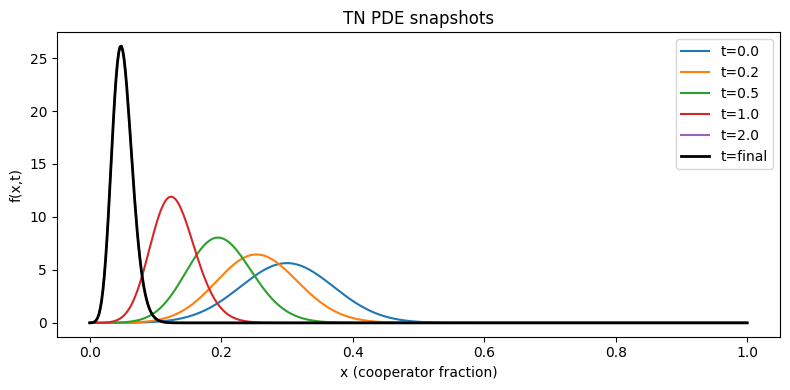

C:\Users\pjw10\OneDrive\ipykernel_6272\3565129308.py:63: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  mean_x = np.trapz(x * f, x)
C:\Users\pjw10\OneDrive\ipykernel_6272\3565129308.py:64: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  var_x = np.trapz((x - mean_x)**2 * f, x)
C:\Users\pjw10\OneDrive\ipykernel_6272\3565129308.py:65: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  meanG = np.trapz(G * f, x)
C:\Users\pjw10\OneDrive\ipykernel_6272\3565129308.py:68: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  entropy = -np.trapz(f * np.log(f + eps), x)


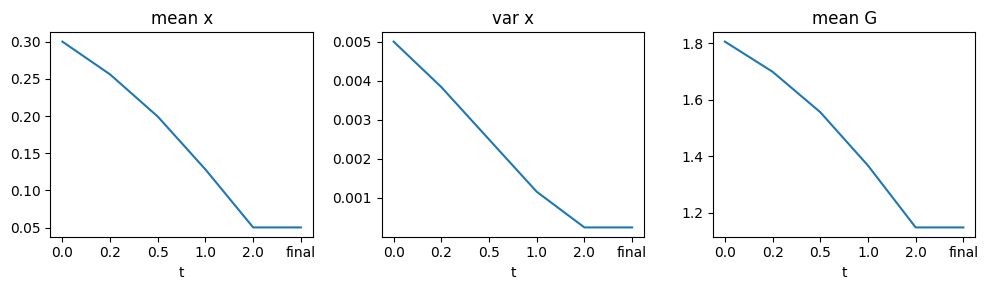

C:\Users\pjw10\OneDrive\ipykernel_6272\3565129308.py:79: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  mean_x = np.trapz(x * f_final, x)


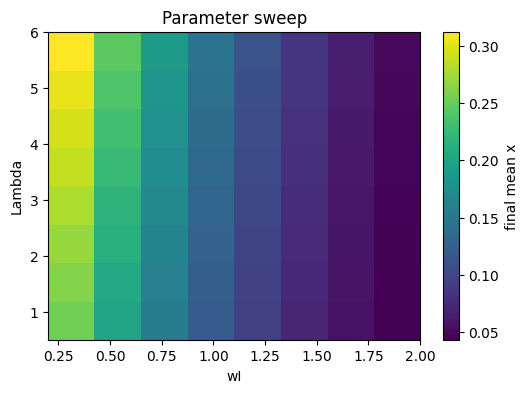

C:\Users\pjw10\OneDrive\ipykernel_6272\3565129308.py:88: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  f /= np.trapz(f, x)
C:\Users\pjw10\OneDrive\ipykernel_6272\3565129308.py:96: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  D = np.trapz(np.exp(wG * G) * f, x)
C:\Users\pjw10\OneDrive\ipykernel_6272\3565129308.py:101: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  f /= np.trapz(f, x)
C:\Users\pjw10\OneDrive\ipykernel_6272\3565129308.py:105: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  meanxs.append(np.trapz(x*f,x))


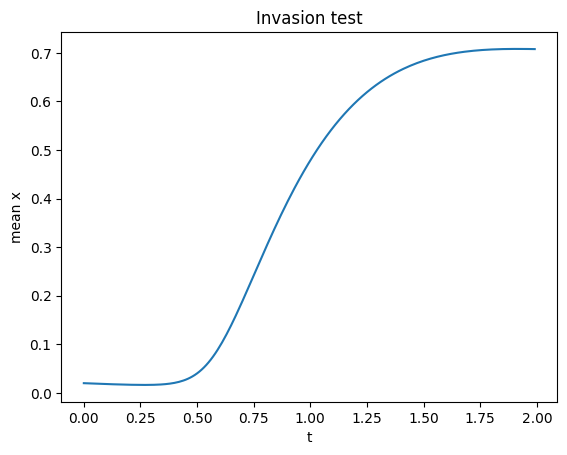

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def fitnesses(x, R, S, T, P):
    piC = R * x + S * (1 - x)
    piD = T * x + P * (1 - x)
    G = piC * x + piD * (1 - x)
    return piC, piD, G

def upwind_step(f, x, dx, dt, v, growth):
    """One conservative upwind step for -∂x(v f) + growth*f.
       v: velocity array on grid points, growth: growth rate array on grid points.
    """
    v_plus = np.maximum(v, 0.0)
    v_minus = np.minimum(v, 0.0)

    flux = v_plus * f + np.roll(v_minus * f, -1) # flux[i] = (vf)_{i+1/2}
    flux[-1] = 0.0
    div = (flux - np.roll(flux, 1)) / dx # (vf)_{i+1/2} - (vf)_{i-1/2}
    dfdt = -div + growth * f
    return dfdt

def run_pde(R, S, T, P, Lambda, wI, wG,
            x, dt, tmax, f0,
            save_times):
    dx = x[1] - x[0]
    f = f0.copy()
    t = 0.0
    snapshots = {}
    times_to_save = set(save_times)
    # store initial if requested
    if 0.0 in times_to_save:
        snapshots[0.0] = f.copy()

    nsteps = int(np.ceil(tmax / dt))
    for step in range(nsteps):
        piC, piD, G = fitnesses(x, R, S, T, P)
        v = wI * x * (1 - x) * (piC - piD)
        D = np.trapz(np.exp(wG * G) * f, x)
        growth = Lambda * (np.exp(wG * G) / D - 1.0)

        dfdt = upwind_step(f, x, dx, dt, v, growth)
        f = f + dt * dfdt

        # positivity and renormalize
        f = np.maximum(f, 0.0)
        total = np.trapz(f, x)
        if total <= 0:
            f = np.ones_like(f) / (x[-1] - x[0])
            total = np.trapz(f, x)
        f /= total
        t += dt
        for st in save_times:
            if abs(t - st) < 0.5*dt:
                snapshots[st] = f.copy()
    # ensure we have last time
    snapshots['final'] = f.copy()
    return snapshots

# Diagnostics: moments, mean G, entropy ???
def diagnostics(x, f, R, S, T, P):
    piC, piD, G = fitnesses(x, R, S, T, P)
    mean_x = np.trapz(x * f, x)
    var_x = np.trapz((x - mean_x)**2 * f, x)
    meanG = np.trapz(G * f, x)
    # Shannon-like entropy
    eps = 1e-12
    entropy = -np.trapz(f * np.log(f + eps), x)
    return {'mean_x': mean_x, 'var_x': var_x, 'meanG': meanG, 'entropy': entropy}

def sweep_Lambda_wI(L_vals, wI_vals, R,S,T,P, wG, x, dt, tmax, f0):
    heat = np.zeros((len(L_vals), len(wI_vals)))
    for i,L in enumerate(L_vals):
        for j,wI in enumerate(wI_vals):
            snaps = run_pde(R,S,T,P, Lambda=L, wI=wI, wG=wG,
                            x=x, dt=dt, tmax=tmax, f0=f0,
                            save_times=[tmax])
            f_final = snaps.get(tmax, snaps['final'])
            mean_x = np.trapz(x * f_final, x)
            heat[i,j] = mean_x
    return heat

# Invasion test: start near x=0 (almost all defectors) with tiny coop mass
def invasion_test(R,S,T,P, Lambda, wI, wG, x, dt, tmax):
    # initial: bulk at x=0 plus tiny gaussian near small x0
    f = np.ones_like(x) * 1e-6
    f += np.exp(-(x - 0.02)**2 / (2*(0.005**2)))  # tiny coop blob around 0.02
    f /= np.trapz(f, x)
    times = []
    meanxs = []
    t=0.0
    nsteps = int(np.ceil(tmax/dt))
    for step in range(nsteps):
        piC, piD, G = fitnesses(x, R, S, T, P)
        v = wI * x * (1-x) * (piC - piD)
        D = np.trapz(np.exp(wG * G) * f, x)
        growth = Lambda * (np.exp(wG * G) / D - 1.0)
        dfdt = upwind_step(f, x, x[1]-x[0], dt, v, growth)
        f = f + dt * dfdt
        f = np.maximum(f, 0.0)
        f /= np.trapz(f, x)
        t += dt
        if step % max(1, nsteps//200) == 0:
            times.append(t)
            meanxs.append(np.trapz(x*f,x))
    return np.array(times), np.array(meanxs), f

# first graph, f vs x in different t(similar with previous)
def plot_snapshots(x, snapshots, title=None):
    plt.figure(figsize=(8,4))
    for k in sorted(snapshots.keys(), key=lambda v: (v!='final', v)):
        if k=='final': continue
        plt.plot(x, snapshots[k], label=f"t={k}")
    plt.plot(x, snapshots['final'], label="t=final", lw=2, color='k')
    plt.xlabel('x (cooperator fraction)')
    plt.ylabel('f(x,t)')
    if title: plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_diagnostics(time_points, diag_list):
    means = [d['mean_x'] for d in diag_list]
    var = [d['var_x'] for d in diag_list]
    meanG = [d['meanG'] for d in diag_list]
    plt.figure(figsize=(10,3))
    plt.subplot(1,3,1); plt.plot(time_points, means); plt.xlabel('t'); plt.title('mean x')
    plt.subplot(1,3,2); plt.plot(time_points, var); plt.xlabel('t'); plt.title('var x')
    plt.subplot(1,3,3); plt.plot(time_points, meanG); plt.xlabel('t'); plt.title('mean G')
    plt.tight_layout()
    plt.show()

if __name__ == '__main__':
    R,S,T,P = 3.0, 0.0, 5.0, 1.0
    Lambda = 3.0
    wI = 1.0
    wG = 1.0
    x = np.linspace(0,1,500)
    dt = 5e-4
    tmax = 2.0

    f0 = np.exp(-((x - 0.3) ** 2) / 0.01)
    f0 /= np.trapz(f0, x)
    save_times = [0.0, 0.2, 0.5, 1.0, tmax]
    snaps = run_pde(R,S,T,P, Lambda, wI, wG, x, dt, tmax, f0, save_times)
    plot_snapshots(x, snaps, title="TN PDE snapshots")

    float_keys = sorted([k for k in snaps.keys() if isinstance(k, float)])
    diag_list = [diagnostics(x, snaps[t], R,S,T,P) for t in float_keys]
    diag_list.append(diagnostics(x, snaps['final'], R,S,T,P))
    times_sorted = float_keys + ['final']
    plot_diagnostics(times_sorted, diag_list)

    L_vals = np.linspace(0.5, 6.0, 8)
    wI_vals = np.linspace(0.2, 2.0, 8)
    heat = sweep_Lambda_wI(L_vals, wI_vals, R,S,T,P, wG, x, dt, 1.0, f0)
    plt.figure(figsize=(6,4)); plt.imshow(heat, origin='lower',
               extent=[wI_vals[0], wI_vals[-1], L_vals[0], L_vals[-1]], aspect='auto')
    plt.colorbar(label='final mean x'); plt.xlabel('wI'); plt.ylabel('Lambda'); plt.title('Parameter sweep'); plt.show()

    # invasion test(begin when x=0, and see the chaning of x)
    times, meanxs, f_end = invasion_test(R,S,T,P, Lambda, wI, wG, x, dt, 2.0)
    plt.plot(times, meanxs); plt.xlabel('t'); plt.ylabel('mean x'); plt.title('Invasion test'); plt.show()


In [3]:
import sympy as sp
from sympy import symbols, simplify
from sympy import ratsimp
# 定义符号
f0, f1, f2 = sp.symbols('f0 f1 f2', real=True, nonnegative=True)
Lambda, a, b, c, d, e = sp.symbols('Lambda a b c d e', real=True)
omega_G, P, G1, G2, D = sp.symbols('omega_G P G1 G2 D', real=True, positive=True)

# f3 用约束代替
f3 = 1 - f0 - f1 - f2

# df0/dt
df0 = (1-Lambda)*(- f0*a + f1*b) + Lambda*f0*(sp.exp(omega_G*P)/D - 1)

# df1/dt
df1 = (1-Lambda)*(- f1*(c+2*b) + f0*a + 2*f2*d) + Lambda*f1*(sp.exp(omega_G*G1)/D - 1)

# df2/dt
df2 = (1-Lambda)*(- f2*(2*e + d) + 2*f1*b + f3) + Lambda*f2*(sp.exp(omega_G*G2)/D - 1)

# 求解 df/dt = 0
sol = sp.solve([df0, df1, df2], (f0, f1, f2), dict=True)

# 对每个解字典里的表达式进行 simplify
sol = sp.solve([df0, df1, df2], (f0, f1, f2), dict=True)

sol_simplified = []
for s in sol:
    s_simpl = {var: ratsimp(expr) for var, expr in s.items()}
    sol_simplified.append(s_simpl)

for s in sol_simplified:
    for var, expr in s.items():
        print(f"{var} = {expr}")

f0 = (-2*D**3*Lambda**3*b*d + 6*D**3*Lambda**2*b*d - 6*D**3*Lambda*b*d + 2*D**3*b*d)/(3*D**3*Lambda**3*a*b*d - 2*D**3*Lambda**3*a*b*e - D**3*Lambda**3*a*c*d - 2*D**3*Lambda**3*a*c*e - D**3*Lambda**3*a*d + 2*D**3*Lambda**3*a*e - 4*D**3*Lambda**3*b*d + 4*D**3*Lambda**3*b*e + D**3*Lambda**3*c*d + 2*D**3*Lambda**3*c*e + D**3*Lambda**3*d - 2*D**3*Lambda**3*e - 9*D**3*Lambda**2*a*b*d + 6*D**3*Lambda**2*a*b*e + D**3*Lambda**2*a*b + 3*D**3*Lambda**2*a*c*d + 6*D**3*Lambda**2*a*c*e + D**3*Lambda**2*a*c + 4*D**3*Lambda**2*a*d - 4*D**3*Lambda**2*a*e - D**3*Lambda**2*a + 10*D**3*Lambda**2*b*d - 8*D**3*Lambda**2*b*e - 2*D**3*Lambda**2*b - 2*D**3*Lambda**2*c*d - 4*D**3*Lambda**2*c*e - D**3*Lambda**2*c - 3*D**3*Lambda**2*d + 2*D**3*Lambda**2*e + D**3*Lambda**2 + 9*D**3*Lambda*a*b*d - 6*D**3*Lambda*a*b*e - 2*D**3*Lambda*a*b - 3*D**3*Lambda*a*c*d - 6*D**3*Lambda*a*c*e - 2*D**3*Lambda*a*c - 5*D**3*Lambda*a*d + 2*D**3*Lambda*a*e + D**3*Lambda*a - 8*D**3*Lambda*b*d + 4*D**3*Lambda*b*e + 2*D**3*Lambda*b + D

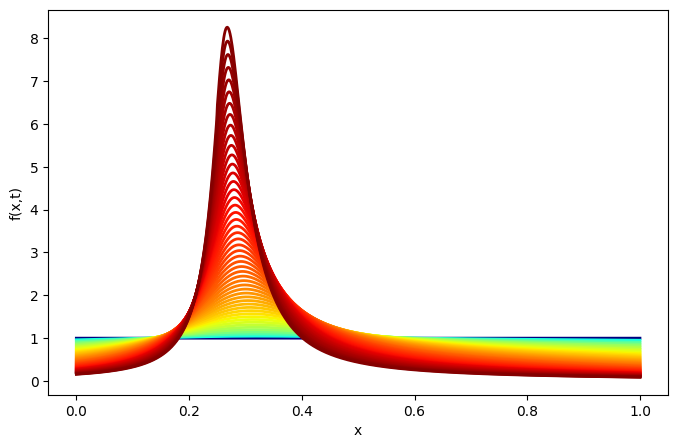

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm


N = 800
dt = 0.0005
time_steps = 5000
# dt = 0.001
# time_steps = 20000
wi = 1
wg = 1
Lambda = 0.1
# R, S, T, P = 6, 3, 12, 5 #PD
R, S, T, P = 6, 5, 12, 3 #HD

x_interface = np.linspace(0, 1, N+1)
dx = x_interface[1] - x_interface[0]
x_center = 0.5 * (x_interface[1:] + x_interface[:-1])


def theta_init(j, N, theta):
    return N ** (1.0 - theta) * (((N - j) ** theta) - ((N - j - 1.0) ** theta))
theta_vec = np.vectorize(theta_init)
index_holder = np.arange(N, dtype=float)
f_j = theta_vec(index_holder, N, 1.0)
f_j /= np.sum(f_j * dx)


def coop_payoff(x):
    numer = np.exp(wi * (x*R + (1-x)*S))
    denom = x*np.exp(wi * (x*R + (1-x)*S)) + (1-x)*np.exp(wi * (x*T + (1-x)*P))
    return numer / denom

def def_payoff(x):
    numer = np.exp(wi * (x*T + (1-x)*P))
    denom = x*np.exp(wi * (x*R + (1-x)*S)) + (1-x)^np.exp(wi * (x*T + (1-x)*P))
    return numer / denom

def G(x):
    return x * (x*R + (1-x)*S) + (1-x)*(x*T + (1-x)*P)

# def G_group(f):
#     exp_wgG_centers = np.exp(wg * G(x_center))
#     denom = np.sum(f * exp_wgG_centers) * dx
#     if denom == 0:
#         denom = 1e-20
#     return exp_wgG_centers / denom 

def flux(f):
    F = np.zeros(N+1)
    for j in range(N+1):
        x = x_interface[j]
        v = x*(1-x)*(coop_payoff(x)-def_payoff(x))
        
        if v >= 0:
            f_up = f[j-1] if j>0 else f[0]
        else:
            f_up = f[j] if j<N else f[-1]
        F[j] = v * f_up
    return F

def cell_trapz_integrals_local(f):
    I = np.zeros(N)
    J = np.zeros(N)
    
    denom = np.sum(f * np.exp(wg * G(x_center))) * dx
    if denom == 0:
        denom = 1e-20

    for j in range(N):
        xL, xR = x_interface[j], x_interface[j+1]
        fL, fR = f[j], f[j]
        if j < N-1:
            fR = f[j+1]
        
        G_L = np.exp(wg * G(xL)) / denom
        G_R = np.exp(wg * G(xR)) / denom
        I[j] = 0.5 * dx * (G_L * fL + G_R * fR)
        J[j] = 0.5 * dx * (fL + fR)
    
    return I, J


plt.figure(figsize=(8,5))

for n in range(time_steps):

    # G_vals = G_group(x_center)
    # df_selection = Lambda * (G_vals * f_j - f_j) * dx
    I_cell, J_cell = cell_trapz_integrals_local(f_j)
    df_selection = Lambda * (I_cell - J_cell)


    F = flux(f_j)
    df_transport = -(F[1:] - F[:-1])/dx

    f_j_new = f_j + dt * (df_transport + df_selection)
    f_j_new = np.maximum(f_j_new, 0)
    current_sum_f_j = np.sum(f_j_new)

    if current_sum_f_j > 0:
        f_j_new = f_j_new * (N / current_sum_f_j)
    else:
        f_j_new = np.ones_like(f_j_new)
        f_j_new = f_j_new * (N / np.sum(f_j_new))
    f_j = f_j_new
    
    if n % 100 == 0:
        color_val = cm.jet((n / time_steps)**0.25)
        plt.plot(x_center, f_j, color=color_val, lw=2)

# idx_max = np.argmax(f_j)
# print("Final peak at x =", x_center[idx_max])
# print("distance to 0.25:", abs(x_center[idx_max] - 0.25))


plt.xlabel('x')
plt.ylabel('f(x,t)')
plt.show()


Final peak at x = 0.040625
distance to 0: 0.040625


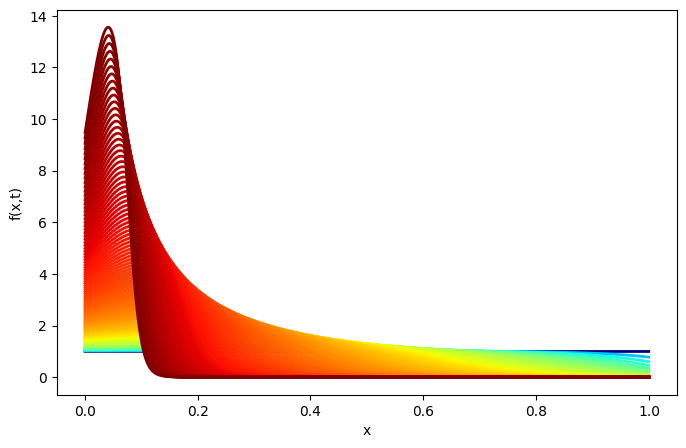

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm


N = 800
dt = 0.0005
time_steps = 10000
wi = 0.3
wg = 1
Lambda = 0.1
R, S, T, P = 6, 3, 12, 5 #PD
# R, S, T, P = 6, 5, 12, 3 #HD
x_interface = np.linspace(0, 1, N+1)
dx = x_interface[1] - x_interface[0]
x_center = 0.5 * (x_interface[1:] + x_interface[:-1])


def theta_init(j, N, theta):
    return N ** (1.0 - theta) * (((N - j) ** theta) - ((N - j - 1.0) ** theta))
theta_vec = np.vectorize(theta_init)
index_holder = np.arange(N, dtype=float)
f_j = theta_vec(index_holder, N, 1.0)
f_j /= np.sum(f_j * dx)


def coop_payoff(x):
    numer = np.exp(wi * (x*R + (1-x)*S))
    denom = x*np.exp(wi * (x*R + (1-x)*S)) + (1-x)*np.exp(wi * (x*T + (1-x)*P))
    return numer / denom

def def_payoff(x):
    numer = np.exp(wi * (x*T + (1-x)*P))
    denom = x*np.exp(wi * (x*R + (1-x)*S)) + (1-x)*np.exp(wi * (x*T + (1-x)*P))
    return numer / denom

def G(x):
    return x * (x*R + (1-x)*S) + (1-x)*(x*T + (1-x)*P)

def G_group(f):
    exp_wgG_centers = np.exp(wg * G(x_center))
    denom = np.sum(f * exp_wgG_centers) * dx
    if denom == 0:
        denom = 1e-20
    return exp_wgG_centers / denom

def flux(f):
    F = np.zeros(N+1)
    for j in range(N+1):
        x = x_interface[j]
        v = x*(1-x)*(coop_payoff(x)-def_payoff(x))

        if v >= 0:
            f_up = f[j-1] if j>0 else f[0]
        else:
            f_up = f[j] if j<N else f[-1]
        F[j] = v * f_up
    return F

def cell_trapz_integrals_local(f):
    I = np.zeros(N)
    J = np.zeros(N)

    denom = np.sum(f * np.exp(wg * G(x_center))) * dx
    if denom == 0:
        denom = 1e-20

    for j in range(N):
        xL, xR = x_interface[j], x_interface[j+1]
        fL, fR = f[j], f[j]
        if j < N-1:
            fR = f[j+1]

        G_L = np.exp(wg * G(xL)) / denom
        G_R = np.exp(wg * G(xR)) / denom
        I[j] = 0.5 * dx * (G_L * fL + G_R * fR)
        J[j] = 0.5 * dx * (fL + fR)

    return I, J


plt.figure(figsize=(8,5))

for n in range(time_steps):

    G_vals = G_group(x_center)
    df_selection = Lambda * (G_vals * f_j - f_j) * dx
    I_cell, J_cell = cell_trapz_integrals_local(f_j)
    df_selection = Lambda * (I_cell - J_cell)


    F = flux(f_j)
    df_transport = -(F[1:] - F[:-1])/dx

    f_j_new = f_j + dt * (df_transport + df_selection)
    f_j_new = np.maximum(f_j_new, 0)
    current_sum_f_j = np.sum(f_j_new)

    if current_sum_f_j > 0:
        f_j_new = f_j_new * (N / current_sum_f_j)
    else:
        f_j_new = np.ones_like(f_j_new)
        f_j_new = f_j_new * (N / np.sum(f_j_new))
    f_j = f_j_new

    if n % 100 == 0:
        color_val = cm.jet((n / time_steps)**0.25)
        plt.plot(x_center, f_j, color=color_val, lw=2)


idx_max = np.argmax(f_j)
print("Final peak at x =", x_center[idx_max])
print("distance to 0:", abs(x_center[idx_max]))

plt.xlabel('x')
plt.ylabel('f(x,t)')
plt.show()


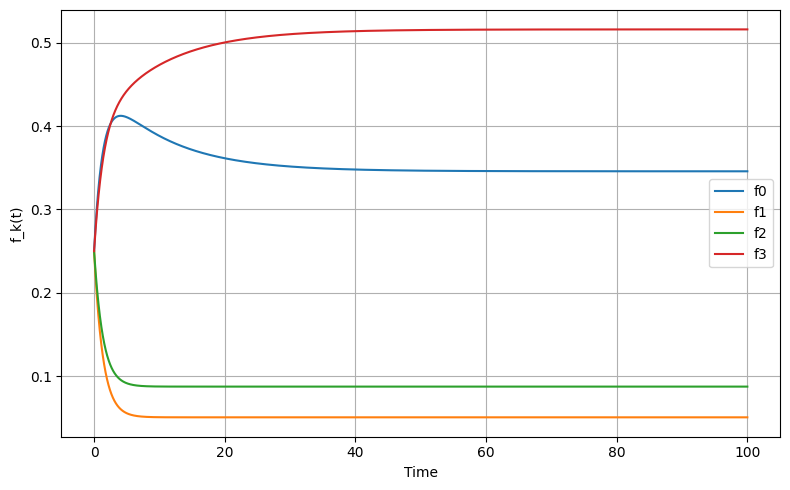

Equilibrium point:
[0.34575066 0.05074767 0.08758421 0.51591745] 

Eigenvalues of Jacobian:
[-2.19010896e+00 -7.39515518e-01  3.52941387e-11 -9.99957983e-02] 

=> Equilibrium is UNSTABLE.
1.2465800118728525e+43
1.2204032943178408e+39
3.4934271057485095e+19


In [26]:
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
import numpy.linalg as LA

R, S, T, P = 6, 5, 12, 3 #HD
# R, S, T, P = 6, 3, 12, 5 #PD
omega_I = 0.1
omega_G = 15
Lambda = 0.1

def pi_C(x):
    return x*R + (1-x)*S

def pi_D(x):
    return x*T + (1-x)*P

def G(x):
    return x*pi_C(x) + (1-x)*pi_D(x)

W1 = np.exp(omega_I * (R+2*S)/3) + 2*np.exp(omega_I * (T+2*P)/3)
W2 = 2*np.exp(omega_I * (2*R+S)/3) + np.exp(omega_I * (2*T+P)/3)
def dfdt(f):
    f0, f1, f2, f3 = f

    D = (
        f0*np.exp(omega_G*P)
        + f1*np.exp(omega_G*(R+2*S+2*T+4*P)/9)
        + f2*np.exp(omega_G*(4*R+2*S+2*T+P)/9)
        + f3*np.exp(omega_G*R)
    )

    df0 = (
        f1 * (2*np.exp(omega_I*pi_D(1/3)) / W1)
        + Lambda * f0 * (np.exp(omega_G*P)/D - 1)
    )
    df1 = (
        -f1*(2*np.exp(omega_I*(T+2*P)/3)/W1)
        -f1*(2*np.exp(omega_I*(R+2*S)/3)/W1)
        + f2*(2*np.exp(omega_I*(2*T+P)/3)/W2)
        + Lambda*f1*(np.exp(omega_G*(R+2*S+2*T+4*P)/9)/D - 1)
    )

    df2 = (
        -f2*(2*np.exp(omega_I*(2*T+P)/3)/W2)
        -f2*(2*np.exp(omega_I*(2*R+S)/3)/W2)
        + f1*(2*np.exp(omega_I*(R+2*S)/3)/W1)
        + Lambda*f2*(np.exp(omega_G*(4*R+2*S+2*T+P)/9)/D - 1)
    )

    # df3
    df3 = (
        f2*(2*np.exp(omega_I*(2*R+S)/3)/W2)
        + Lambda*f3*(np.exp(omega_G*R)/D - 1)
    )

    return np.array([df0, df1, df2, df3])

def rk4_step(f, dt):
    k1 = dfdt(f)
    k2 = dfdt(f + dt*k1/2)
    k3 = dfdt(f + dt*k2/2)
    k4 = dfdt(f + dt*k3)
    f_new = f + dt*(k1 + 2*k2 + 2*k3 + k4)/6
    return f_new / np.sum(f_new)


Tmax = 100
dt = 0.001
steps = int(Tmax/dt)
f = np.array([0.25, 0.25, 0.25, 0.25])
history = np.zeros((steps, 4))
time = np.linspace(0, Tmax, steps)

for i in range(steps):
    history[i] = f
    f = rk4_step(f, dt)


plt.figure(figsize=(8,5))
plt.plot(time, history[:,0], label="f0")
plt.plot(time, history[:,1], label="f1")
plt.plot(time, history[:,2], label="f2")
plt.plot(time, history[:,3], label="f3")
plt.xlabel("Time")
plt.ylabel("f_k(t)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


#eq points
def equilibrium_equations(f):
    f0, f1, f2, f3 = f
    S = f0 + f1 + f2 + f3
    if S == 0:
        return np.array([1,1,1,1]) 
    f = f / S
    return dfdt(f)
f_guess = np.array([0.25, 0.25, 0.25, 0.25])
eq_f, info, ier, msg = fsolve(equilibrium_equations, f_guess, full_output=True)
eq_f = eq_f / np.sum(eq_f)
print("Equilibrium point:")
print(eq_f, "\n")

#stability
def jacobian(f, eps=1e-6):
    n = len(f)
    J = np.zeros((n,n))
    F0 = dfdt(f)
    
    for j in range(n):
        f_perturb = f.copy()
        f_perturb[j] += eps
        f_perturb /= np.sum(f_perturb)
        F1 = dfdt(f_perturb)
        J[:, j] = (F1 - F0) / eps

    return J
J_eq = jacobian(eq_f)
# print("Jacobian at equilibrium:")
# print(J_eq, "\n")
eigvals, eigvecs = LA.eig(J_eq)
print("Eigenvalues of Jacobian:")
print(eigvals, "\n")

if np.all(np.real(eigvals) < 0):
    print("=> Equilibrium is STABLE.")
elif np.any(np.real(eigvals) > 0):
    print("=> Equilibrium is UNSTABLE.")
else:
    print("=> Equilibrium is NON-HYPERBOLIC (zero real parts).")


f0, f1, f2, f3 = eq_f 
D_eq = (
      f0 * np.exp(omega_G * P)
    + f1 * np.exp(omega_G * (R + 2*S + 2*T + 4*P) / 9)
    + f2 * np.exp(omega_G * (4*R + 2*S + 2*T + P) / 9)
    + f3 * np.exp(omega_G * R)
)
print(D_eq)
print(np.exp(omega_G * R))
print(np.exp(omega_G * P))



Check at wG ~ 15: [0.34574996 0.05074757 0.08758403 0.51591843]


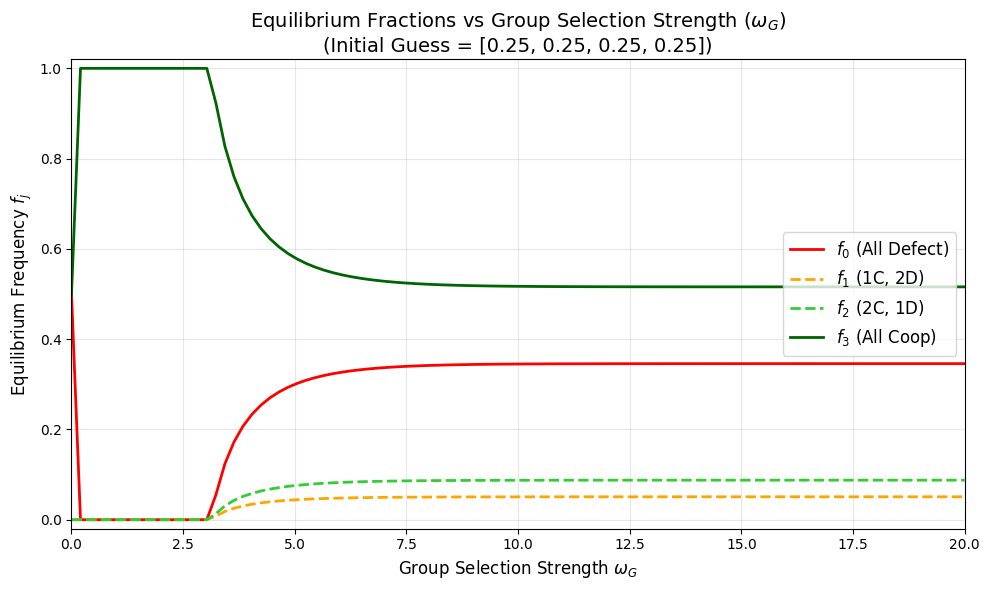

In [115]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
R, S, T, P = 6, 5, 12, 3 # HD
# R, S, T, P = 6, 3, 12, 5 # PD
omega_I = 0.1
Lambda = 0.1
def pi_C(x): return x*R + (1-x)*S
def pi_D(x): return x*T + (1-x)*P
W1 = np.exp(omega_I * (R+2*S)/3) + 2*np.exp(omega_I * (T+2*P)/3)
W2 = 2*np.exp(omega_I * (2*R+S)/3) + np.exp(omega_I * (2*T+P)/3)
fit_0 = P
fit_1 = (R + 2*S + 2*T + 4*P) / 9.0
fit_2 = (4*R + 2*S + 2*T + P) / 9.0
fit_3 = R
current_wG = 0 

def equilibrium_func(f):
    f0, f1, f2, f3 = f
    wG = current_wG 
    E0 = np.exp(wG * fit_0)
    E1 = np.exp(wG * fit_1)
    E2 = np.exp(wG * fit_2)
    E3 = np.exp(wG * fit_3)

    D = f0*E0 + f1*E1 + f2*E2 + f3*E3
    if D == 0: D = 1e-10
    term_in_0 = f1 * (2*np.exp(omega_I*pi_D(1/3)) / W1)
    df0 = term_in_0 + Lambda * f0 * (E0/D - 1)
    term_out_1_to_0 = f1 * (2*np.exp(omega_I*(T+2*P)/3)/W1)
    term_out_1_to_2 = f1 * (2*np.exp(omega_I*(R+2*S)/3)/W1)
    term_in_1_from_2 = f2 * (2*np.exp(omega_I*(2*T+P)/3)/W2)
    df1 = -term_out_1_to_0 - term_out_1_to_2 + term_in_1_from_2 + Lambda*f1*(E1/D - 1)
    term_out_2_to_1 = f2 * (2*np.exp(omega_I*(2*T+P)/3)/W2)
    term_out_2_to_3 = f2 * (2*np.exp(omega_I*(2*R+S)/3)/W2)
    term_in_2_from_1 = f1 * (2*np.exp(omega_I*(R+2*S)/3)/W1)
    df2 = -term_out_2_to_1 - term_out_2_to_3 + term_in_2_from_1 + Lambda*f2*(E2/D - 1)
    term_in_3 = f2 * (2*np.exp(omega_I*(2*R+S)/3)/W2)
    df3 = term_in_3 + Lambda*f3*(E3/D - 1)
    return [df0, df1, df2, f0+f1+f2+f3 - 1.0]
omega_G_values = np.linspace(0, 20, 100)
results = []
for val in omega_G_values:
    current_wG = val
    fixed_guess = [0.25, 0.25, 0.25, 0.25]
    root = fsolve(equilibrium_func, fixed_guess)
    root = np.maximum(root, 0)
    root = root / np.sum(root)
    
    results.append(root)
results = np.array(results)
plt.figure(figsize=(10, 6))
plt.plot(omega_G_values, results[:, 0], label=r'$f_0$ (All Defect)', color='red', linewidth=2)
plt.plot(omega_G_values, results[:, 1], label=r'$f_1$ (1C, 2D)', color='orange', linewidth=2, linestyle='--')
plt.plot(omega_G_values, results[:, 2], label=r'$f_2$ (2C, 1D)', color='limegreen', linewidth=2, linestyle='--')
plt.plot(omega_G_values, results[:, 3], label=r'$f_3$ (All Coop)', color='darkgreen', linewidth=2)
idx_15 = np.argmin(np.abs(omega_G_values - 15))
print(f"Check at wG ~ 15: {results[idx_15]}")
plt.title(f'Equilibrium Fractions vs Group Selection Strength ($\omega_G$)\n(Initial Guess = [0.25, 0.25, 0.25, 0.25])', fontsize=14)
plt.xlabel(r'Group Selection Strength $\omega_G$', fontsize=12)
plt.ylabel(r'Equilibrium Frequency $f_j$', fontsize=12)
plt.ylim(-0.02, 1.02)
plt.xlim(0, 20)
plt.legend(fontsize=12, loc='center right')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

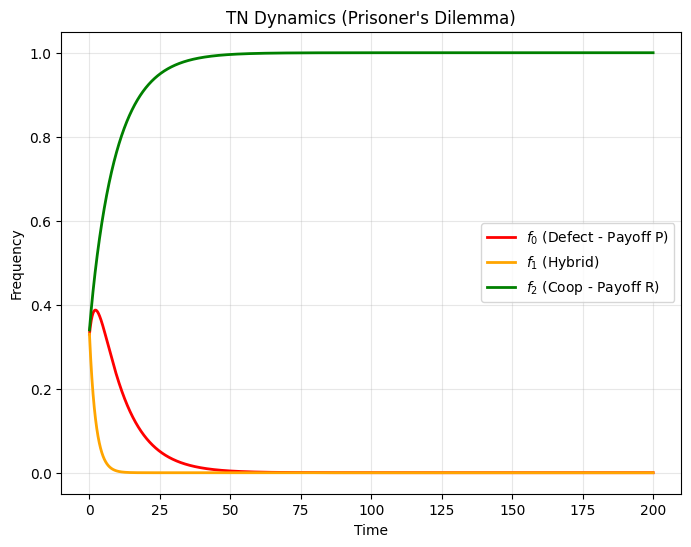

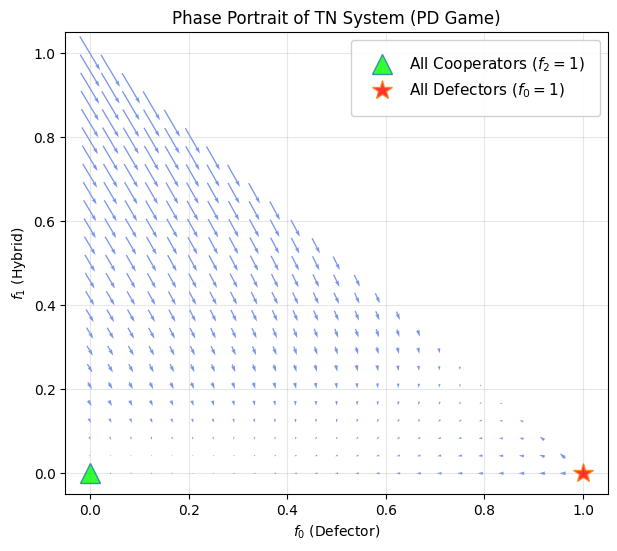

--- Calculating Equilibria for TN System (Exponential) ---
Equilibrium 1:
  Coordinates: f0=0.0000, f1=0.0000, f2=1.0000
  Eigenvalues: [-0.09999997 -0.5       ]
  Result: => STABLE (Sink)
------------------------------




In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
import numpy.linalg as LA

R, S, T, P = 3, 1, 5, 2  # PD 
# R, S, T, P = 3, 2, 5, 1  # HD
w_I,w_G,Lambda = 0.1 ,15, 0.1  
# w_I,w_G,Lambda = 1 ,1, 0.1    

G_1 = (T + S) / 2.0
def TN_system(t, f):
    f0, f1, f2 = f
    term0 = f0 * np.exp(w_G * P)
    term1 = f1 * np.exp(w_G * G_1)
    term2 = f2 * np.exp(w_G * R)
    D = term0 + term1 + term2
    if D == 0: D = 1e-10

    # Equation 1 (f0)
    df0 = (0.5 * (np.exp(w_I * T) / (np.exp(w_I * T) + np.exp(w_I * S))) * f1 
           + Lambda * f0 * ((np.exp(w_G * P) / D) - 1))

    # Equation 2 (f1)
    df1 = (-0.5 * f1 
           + Lambda * f1 * ((np.exp(w_G * G_1) / D) - 1))

    # Equation 3 (f2)
    df2 = (0.5 * (np.exp(w_I * S) / (np.exp(w_I * T) + np.exp(w_I * S))) * f1 
           + Lambda * f2 * ((np.exp(w_G * R) / D) - 1))
           
    return np.array([df0, df1, df2])

# --- 3. 龙格库塔解算器 (画图用) ---
def rk4_step(func, t, y, dt):
    k1 = func(t, y)
    k2 = func(t + 0.5*dt, y + 0.5*dt*k1)
    k3 = func(t + 0.5*dt, y + 0.5*dt*k2)
    k4 = func(t + dt, y + dt*k3)
    return y + (dt / 6.0) * (k1 + 2*k2 + 2*k3 + k4)

def solve_ode(system_func, y0, t_span, dt):
    t_start, t_end = t_span
    t_values = np.arange(t_start, t_end, dt)
    y_values = np.zeros((len(t_values), len(y0)))
    y_current = np.array(y0)
    for i, t in enumerate(t_values):
        y_values[i] = y_current
        # 每步之后归一化，防止数值漂移
        y_next = rk4_step(system_func, t, y_current, dt)
        y_current = y_next / np.sum(y_next) 
    return t_values, y_values


def check_stability(ode_func, equilibrium_point):
    f0_star, f1_star, f2_star = equilibrium_point
    
    # 定义降维后的函数: 输入 [f0, f1], 输出 [df0/dt, df1/dt]
    def reduced_func(f_vec):
        f0, f1 = f_vec
        f2 = 1.0 - f0 - f1
        full_state = np.array([f0, f1, f2])
        derivs = ode_func(0, full_state)
        return derivs[:2] # 只取前两个导数

    # 数值雅可比矩阵 (Finite Difference)
    eps = 1e-7
    J = np.zeros((2, 2))
    val_at_star = reduced_func([f0_star, f1_star])

    # 对 f0 求偏导 (Col 0)
    val_f0_plus = reduced_func([f0_star + eps, f1_star])
    J[:, 0] = (val_f0_plus - val_at_star) / eps

    # 对 f1 求偏导 (Col 1)
    val_f1_plus = reduced_func([f0_star, f1_star + eps])
    J[:, 1] = (val_f1_plus - val_at_star) / eps

    # 计算特征值
    eigvals = LA.eigvals(J)
    
    # 判断稳定性
    # 只要有一个实部 > 0，就是不稳定
    is_stable = np.all(np.real(eigvals) < 0)
    
    return eigvals, is_stable

def find_equilibria(ode_func, name):
    print(f"--- Calculating Equilibria for {name} ---")
    
    def equations(vars):
        f0, f1 = vars
        f2 = 1 - f0 - f1
        state = [f0, f1, f2]
        derivs = ode_func(0, state)
        return derivs[:2]
    # guesses = [ #to find more than one eq point
    #     [0.1, 0.1], 
    #     [0.9, 0.1], 
    #     [0.1, 0.8], 
    #     [0.33, 0.33]
    # ]
    guesses = [ #to find more than one eq point 

        [0.33, 0.33]
    ]
    found_roots = []
    
    for guess in guesses:
        root, info, ier, msg = fsolve(equations, guess, full_output=True)
        
        if ier == 1:
            f0_sol, f1_sol = root
            f2_sol = 1 - f0_sol - f1_sol
            if (f0_sol >= -1e-4 and f1_sol >= -1e-4 and f2_sol >= -1e-4):
                sol = np.array([f0_sol, f1_sol, f2_sol])
                sol = np.clip(sol, 0, 1)
                sol = sol / np.sum(sol)
                
                is_new = True
                for existing in found_roots:
                    if np.allclose(sol, existing, atol=1e-4):
                        is_new = False
                        break
                if is_new:
                    found_roots.append(sol)
    if not found_roots:
        print("No stable equilibria found (or numerical error).")
    else:
        for i, root in enumerate(found_roots):
            print(f"Equilibrium {i+1}:")
            print(f"  Coordinates: f0={root[0]:.4f}, f1={root[1]:.4f}, f2={root[2]:.4f}")
            eigvals, is_stable = check_stability(ode_func, root)
            
            print(f"  Eigenvalues: {eigvals}")
            if is_stable:
                print("  Result: => STABLE (Sink)")
            else:
                print("  Result: => UNSTABLE (Saddle or Source)")
            print("-" * 30)
    print("\n")


f0_init = [0.33, 0.33, 0.34] 
t_span = (0, 200)
dt = 0.001

t1, res1 = solve_ode(TN_system, f0_init, t_span, dt)
fig, ax1 = plt.subplots(1, 1, figsize=(8, 6))
ax1.plot(t1, res1[:, 0], label='$f_0$ (Defect - Payoff P)', linewidth=2, color='red')
ax1.plot(t1, res1[:, 1], label='$f_1$ (Hybrid)', linewidth=2, color='orange')
ax1.plot(t1, res1[:, 2], label='$f_2$ (Coop - Payoff R)', linewidth=2, color='green')
ax1.set_title("TN Dynamics (Prisoner's Dilemma)")
ax1.set_xlabel("Time")
ax1.set_ylabel("Frequency")
ax1.legend()
ax1.grid(True, alpha=0.3)
plt.show()

# phase
N = 25
f0_vals = np.linspace(0, 1, N)
f1_vals = np.linspace(0, 1, N)
U = np.zeros((N, N))
V = np.zeros((N, N))

for i in range(N):
    for j in range(N):
        f0, f1 = f0_vals[j], f1_vals[i]
        if f0 + f1 <= 1: 
            f2 = 1 - f0 - f1
            df = TN_system(0, [f0, f1, f2])
            U[i, j] = df[0]
            V[i, j] = df[1]
        else:
            U[i, j] = np.nan
            V[i, j] = np.nan

plt.figure(figsize=(7, 6))
plt.quiver(f0_vals, f1_vals, U, V, pivot="mid", color="royalblue", alpha=0.7)

plt.title("Phase Portrait of TN System (PD Game)")
plt.xlabel("$f_0$ (Defector)")
plt.ylabel("$f_1$ (Hybrid)")
plt.grid(alpha=0.3)
plt.plot(0, 0, '^', markersize=15, markerfacecolor='#00FF00', alpha=0.8, zorder=10, label='All Cooperators ($f_2=1$)')
plt.plot(1, 0, '*', markersize=15, markerfacecolor='#FF0000', alpha=0.8, zorder=10, label='All Defectors ($f_0=1$)')

plt.legend(loc='upper right', fontsize=11, frameon=True, fancybox=True, framealpha=0.9, borderpad=1)

plt.show()

find_equilibria(TN_system, "TN System (Exponential)")


# Exp_P = np.exp(w_G * P)
# Exp_G1 = np.exp(w_G * G_1)
# Exp_R = np.exp(w_G * R)
# D_stable = Exp_G1 / (1+1/(2*Lambda))
# print(f"  Exp(w_G * P) [Defect Payoff Term] = {Exp_P:.4f}")
# print(f"  Exp(w_G * R) [Coop Payoff Term]   = {Exp_R:.4f}")
# print(f"  Denominator D                     = {D_stable:.4f}")

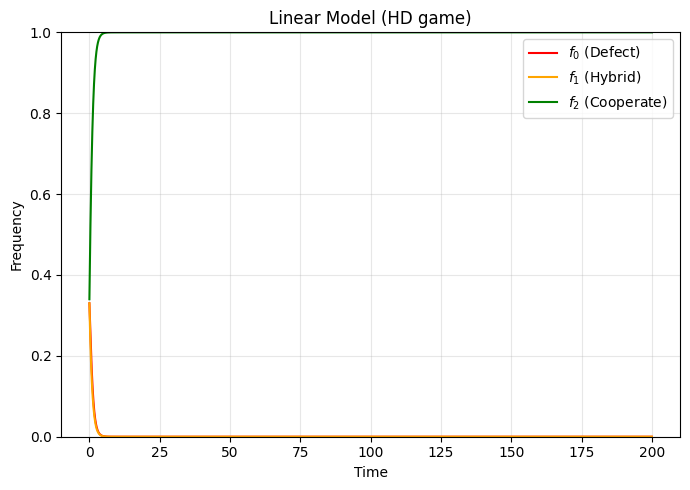

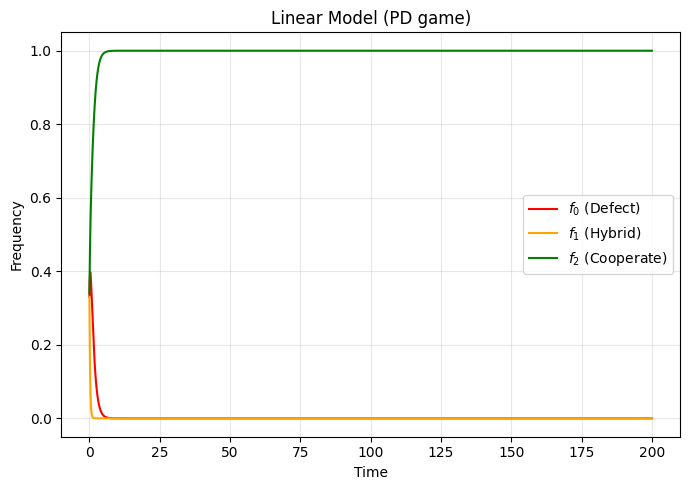

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
import numpy.linalg as LA

def TN_linear_system(t, f, R, S, T, P, w_I, w_G, Lambda):
    f0, f1, f2 = f

    G0 = P
    G1 = (T + S) / 2
    G2 = R

    avgG = G0 * f0 + G1 * f1 + G2 * f2

    df0 = (1 + w_I * T) * f1 \
          + Lambda * w_G * f0 * (P - avgG)

    df1 = -(2 + w_I * (T + S)) * f1 \
          + Lambda * w_G * f1 * (G1 - avgG)

    df2 = (1 + w_I * S) * f1 \
          + Lambda * w_G * f2 * (R - avgG)

    return np.array([df0, df1, df2])
w_I, w_G, Lambda = 0.1, 0.1, 10
f0_init = np.array([0.33, 0.33, 0.34])
t_span = (0, 200)
dt = 0.001
HD = dict(R=6, S=5, T=12, P=3)
PD = dict(R=7, S=3, T=8, P=6) #P>
# PD = dict(R=6, S=3, T=7, P=5) #R>
# PD = dict(R=5, S=3, T=8, P=6) 
def solve(system, y0, params):
    t_vals = np.arange(t_span[0], t_span[1], dt)
    y_vals = np.zeros((len(t_vals), 3))
    y = y0.copy()

    for i, t in enumerate(t_vals):
        y_vals[i] = y
        y = rk4_step(lambda tt, yy: system(tt, yy, **params,
                                            w_I=w_I, w_G=w_G, Lambda=Lambda),
                      t, y, dt)
        y = y / np.sum(y) 

    return t_vals, y_vals
t_HD, res_HD = solve(TN_linear_system, f0_init, HD)
t_PD, res_PD = solve(TN_linear_system, f0_init, PD)

plt.figure(figsize=(7,5))
plt.plot(t_HD, res_HD[:,0], label=r"$f_0$ (Defect)", color="red")
plt.plot(t_HD, res_HD[:,1], label=r"$f_1$ (Hybrid)", color="orange")
plt.plot(t_HD, res_HD[:,2], label=r"$f_2$ (Cooperate)", color="green")

plt.title("Linear Model (HD game)")
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.ylim(0, 1)
plt.show()


plt.figure(figsize=(7,5))
plt.plot(t_PD, res_PD[:,0], label=r"$f_0$ (Defect)", color="red")
plt.plot(t_PD, res_PD[:,1], label=r"$f_1$ (Hybrid)", color="orange")
plt.plot(t_PD, res_PD[:,2], label=r"$f_2$ (Cooperate)", color="green")

plt.title("Linear Model (PD game)")
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


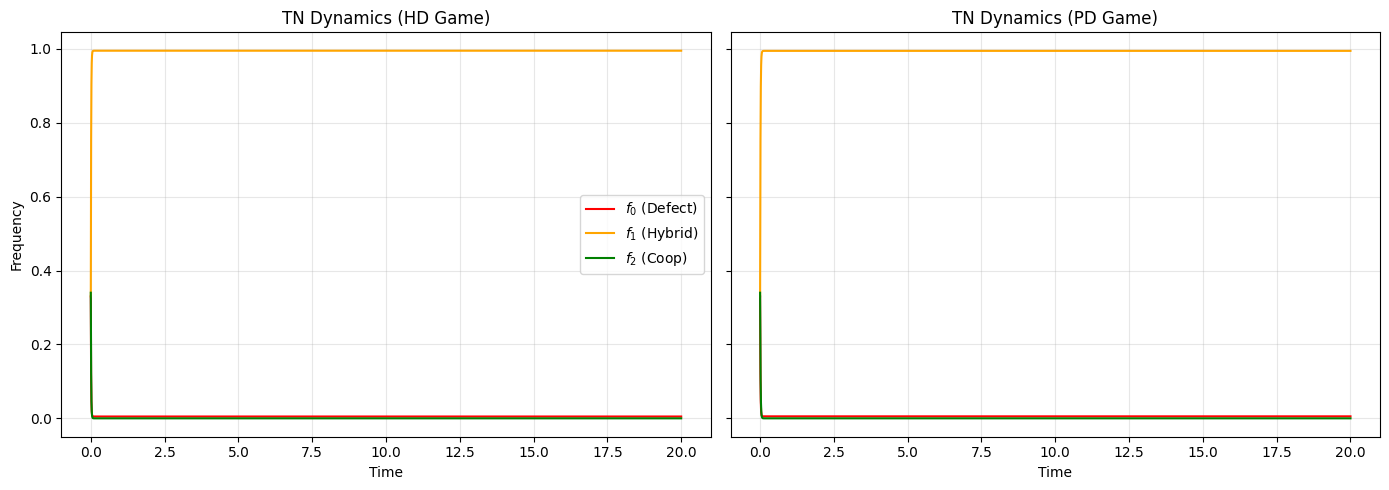

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
import numpy.linalg as LA

HD_params = dict(R=6, S=5, T=12, P=3)
PD_params = dict(R=6, S=3, T=12, P=5)
w_I,w_G,Lambda = 1, 1, 100   

G_1 = (T + S) / 2.0
def make_TN_system(R, S, T, P, w_I, w_G, Lambda):
    G_1 = (T + S) / 2.0

    def TN_system(t, f):
        f0, f1, f2 = f

        term0 = f0 * np.exp(w_G * P)
        term1 = f1 * np.exp(w_G * G_1)
        term2 = f2 * np.exp(w_G * R)
        D = term0 + term1 + term2
        if D == 0:
            D = 1e-10

        df0 = (0.5 * (np.exp(w_I * T) / (np.exp(w_I * T) + np.exp(w_I * S))) * f1
               + Lambda * f0 * ((np.exp(w_G * P) / D) - 1))

        df1 = (-0.5 * f1
               + Lambda * f1 * ((np.exp(w_G * G_1) / D) - 1))

        df2 = (0.5 * (np.exp(w_I * S) / (np.exp(w_I * T) + np.exp(w_I * S))) * f1
               + Lambda * f2 * ((np.exp(w_G * R) / D) - 1))

        return np.array([df0, df1, df2])

    return TN_system

def rk4_step(func, t, y, dt):
    k1 = func(t, y)
    k2 = func(t + 0.5*dt, y + 0.5*dt*k1)
    k3 = func(t + 0.5*dt, y + 0.5*dt*k2)
    k4 = func(t + dt, y + dt*k3)
    return y + (dt / 6.0) * (k1 + 2*k2 + 2*k3 + k4)

def solve_ode(system_func, y0, t_span, dt):
    t_start, t_end = t_span
    t_values = np.arange(t_start, t_end, dt)
    y_values = np.zeros((len(t_values), len(y0)))
    y_current = np.array(y0)
    for i, t in enumerate(t_values):
        y_values[i] = y_current
        y_next = rk4_step(system_func, t, y_current, dt)
        y_current = y_next / np.sum(y_next) 
    return t_values, y_values


f0_init = [0.33, 0.33, 0.34] 
t_span = (0, 20)
dt = 0.0001

TN_HD = make_TN_system(**HD_params, w_I=w_I, w_G=w_G, Lambda=Lambda)
TN_PD = make_TN_system(**PD_params, w_I=w_I, w_G=w_G, Lambda=Lambda)

t_HD, res_HD = solve_ode(TN_HD, f0_init, t_span, dt)
t_PD, res_PD = solve_ode(TN_PD, f0_init, t_span, dt)


fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

# -------- HD --------
axes[0].plot(t_HD, res_HD[:, 0], label='$f_0$ (Defect)', color='red')
axes[0].plot(t_HD, res_HD[:, 1], label='$f_1$ (Hybrid)', color='orange')
axes[0].plot(t_HD, res_HD[:, 2], label='$f_2$ (Coop)', color='green')
axes[0].set_title("TN Dynamics (HD Game)")
axes[0].set_xlabel("Time")
axes[0].set_ylabel("Frequency")
axes[0].legend()
axes[0].grid(alpha=0.3)

# -------- PD --------
axes[1].plot(t_PD, res_PD[:, 0], label='$f_0$ (Defect)', color='red')
axes[1].plot(t_PD, res_PD[:, 1], label='$f_1$ (Hybrid)', color='orange')
axes[1].plot(t_PD, res_PD[:, 2], label='$f_2$ (Coop)', color='green')
axes[1].set_title("TN Dynamics (PD Game)")
axes[1].set_xlabel("Time")
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()
